In [9]:
import os
import cv2
from skimage import io, color, transform


# Carreguem les imatges d'entrenament (FONT MATRÍCULA ESPANYOLA)
def load_images_from_folder_synthetic(folder, label, image_size=(32, 32)):
    images = list()
    labels = list()
    # Per cada imatge de la carpeta, les processem i etiquetem
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = io.imread(img_path)
            # Transformem a l'escala HSV i ens quedem amb la capa V
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            img = img[:, :, 2] 
            # Apliquem un GaussianBlur
            cv2.GaussianBlur(img, (5, 5), 0)
            #threshold de otsu
            thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) [1]
            #Invertim la imatge, l'ajustem a una mida concreta, i l'aplanem
            negative_image = 255 - thresh
            img_resized = transform.resize(negative_image, image_size, anti_aliasing=True)
            img_flatten = img_resized.flatten()
            #Afegim la imatge i la seva etiqueta a les llistes corresponents
            images.append(img_flatten)
            labels.append(label)
            
    return images, labels


# Carreguem les imatges d'entrenament (FONT MATRÍCULA ESPANYOLA)
def load_images_from_folder_real(folder, label, image_size=(32, 32)):
    images = list()
    labels = list()
    # Per cada imatge de la carpeta, les processem i etiquetem
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = io.imread(img_path)
            img_resized = transform.resize(img, image_size, anti_aliasing=True)
            img_flatten = img_resized.flatten()
            #Afegim la imatge i la seva etiqueta a les llistes corresponents
            images.append(img_flatten)
            labels.append(label)
            
    return images, labels

In [10]:

import matplotlib.pyplot as plt

def plot_predictions(X_test, y_test, y_pred):
    # Podem ajustar el numero de mostres, segons la llargada del dataset, com es petit hem posat que mostri totes.
    num_samples = len(y_test)
    # Número de columnes i files per visualitzar-ho millor
    cols = 10  
    rows = (num_samples + cols - 1) // cols  

    plt.figure(figsize=(15, rows * 1.5))
    
    # Per cada mostra mostrem la imatge, la etiqueta real i la seva predicció
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        img = X_test[i].reshape(32, 32)  # 
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Real: {y_test[i]}\nPred: {y_pred[i]}")
    
    plt.tight_layout()
    plt.show()


In [11]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 


def Train_KFolds(X,Y):
    
    # Inicialitzem el model SVC
    clf = svm.SVC(kernel='linear', probability=True)

    # Inicialitzem llistes per guardar les etiquetes predites i reals del dataset i les accuracies dels Kfolds
    accuracies = [] 
    all_y_true = []
    all_y_pred = []
    
    
    # Cridem la funció KFold per generar 5 subconjunts
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  
    
    # Ejecutar el bucle de K-Folds
    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Entrenem el model
        clf.fit(X_train, y_train)
        
        # Realitzem les prediccions amb el conjunt de prova
        y_pred = clf.predict(X_test)
        
        # Calculem y emmagatzem la accuracy del fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Mostrem els resultats del fold actual
        print(f'Fold {fold} - Precisión: {accuracy:.2f}')
        
        # Acumulem les etiquetes reals i predites a les llistes corresponents
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        # Visualitzem les prediccions
        plot_predictions(X_test, y_test, y_pred) 
        
    return kf, all_y_true, all_y_pred, accuracies, clf

Fold 1 - Precisión: 0.96


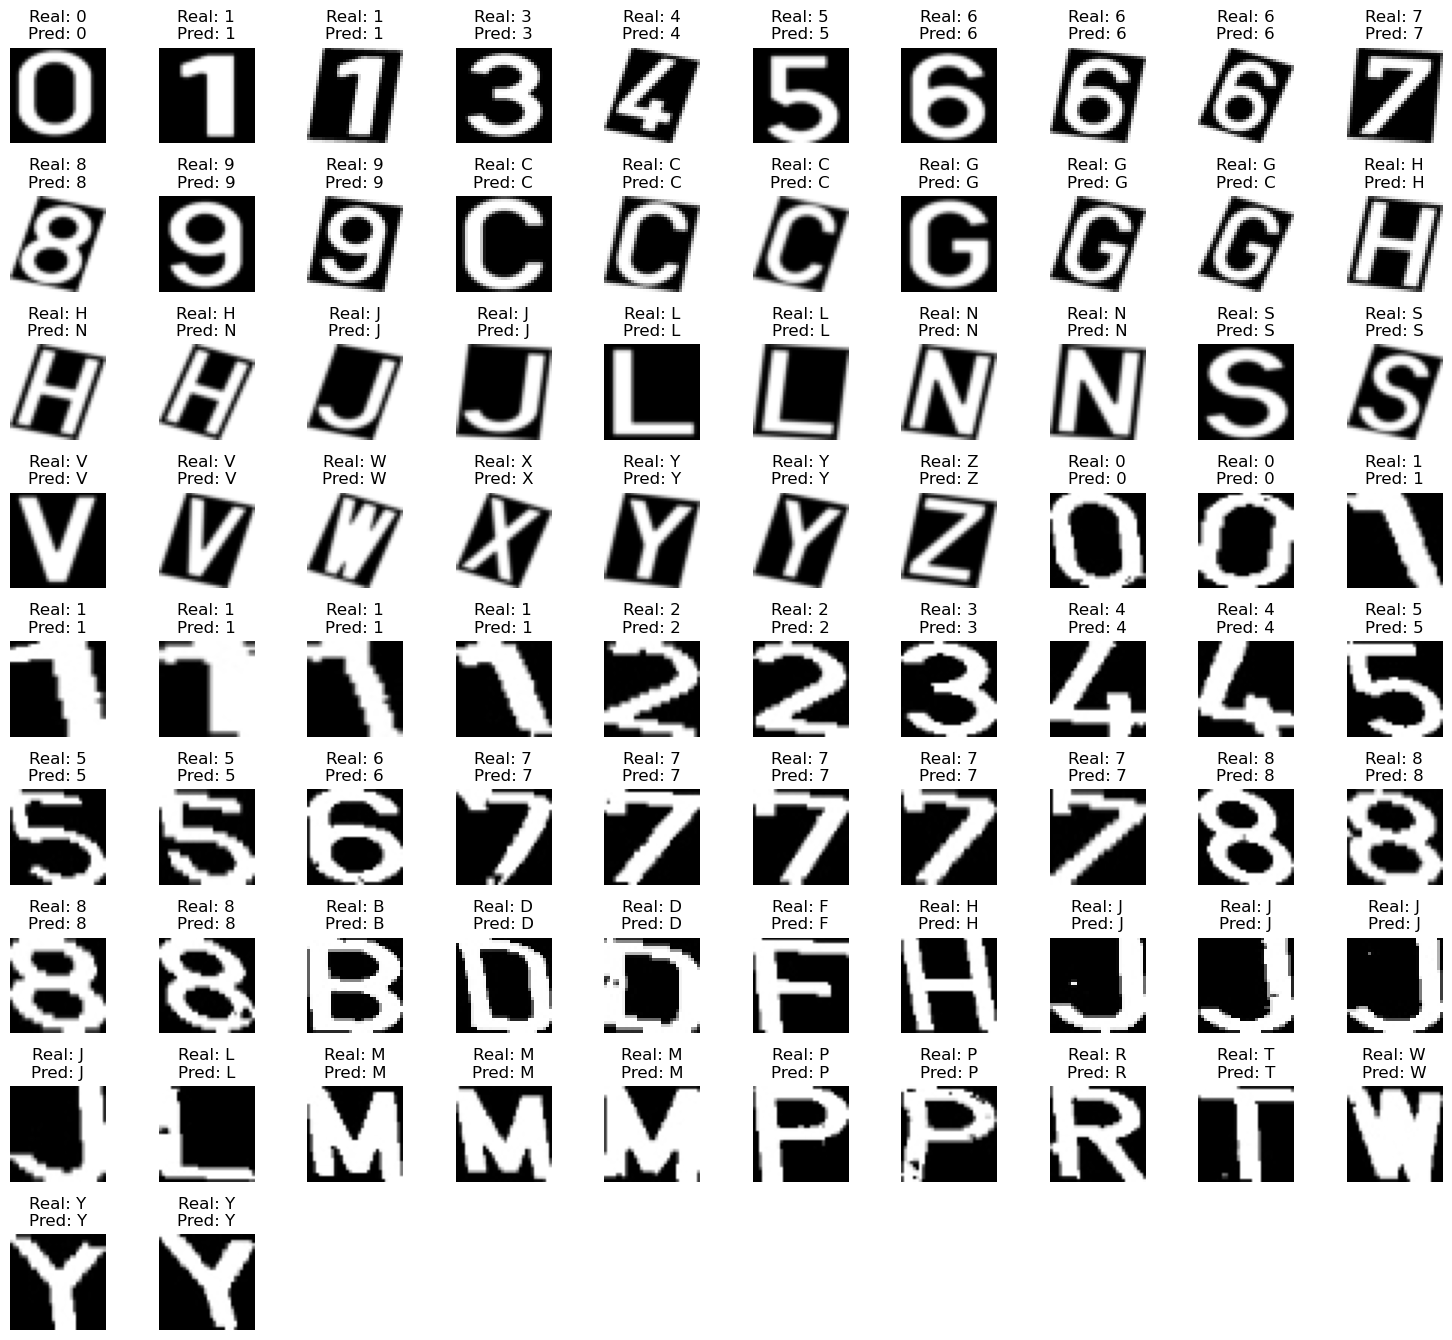

Fold 2 - Precisión: 0.91


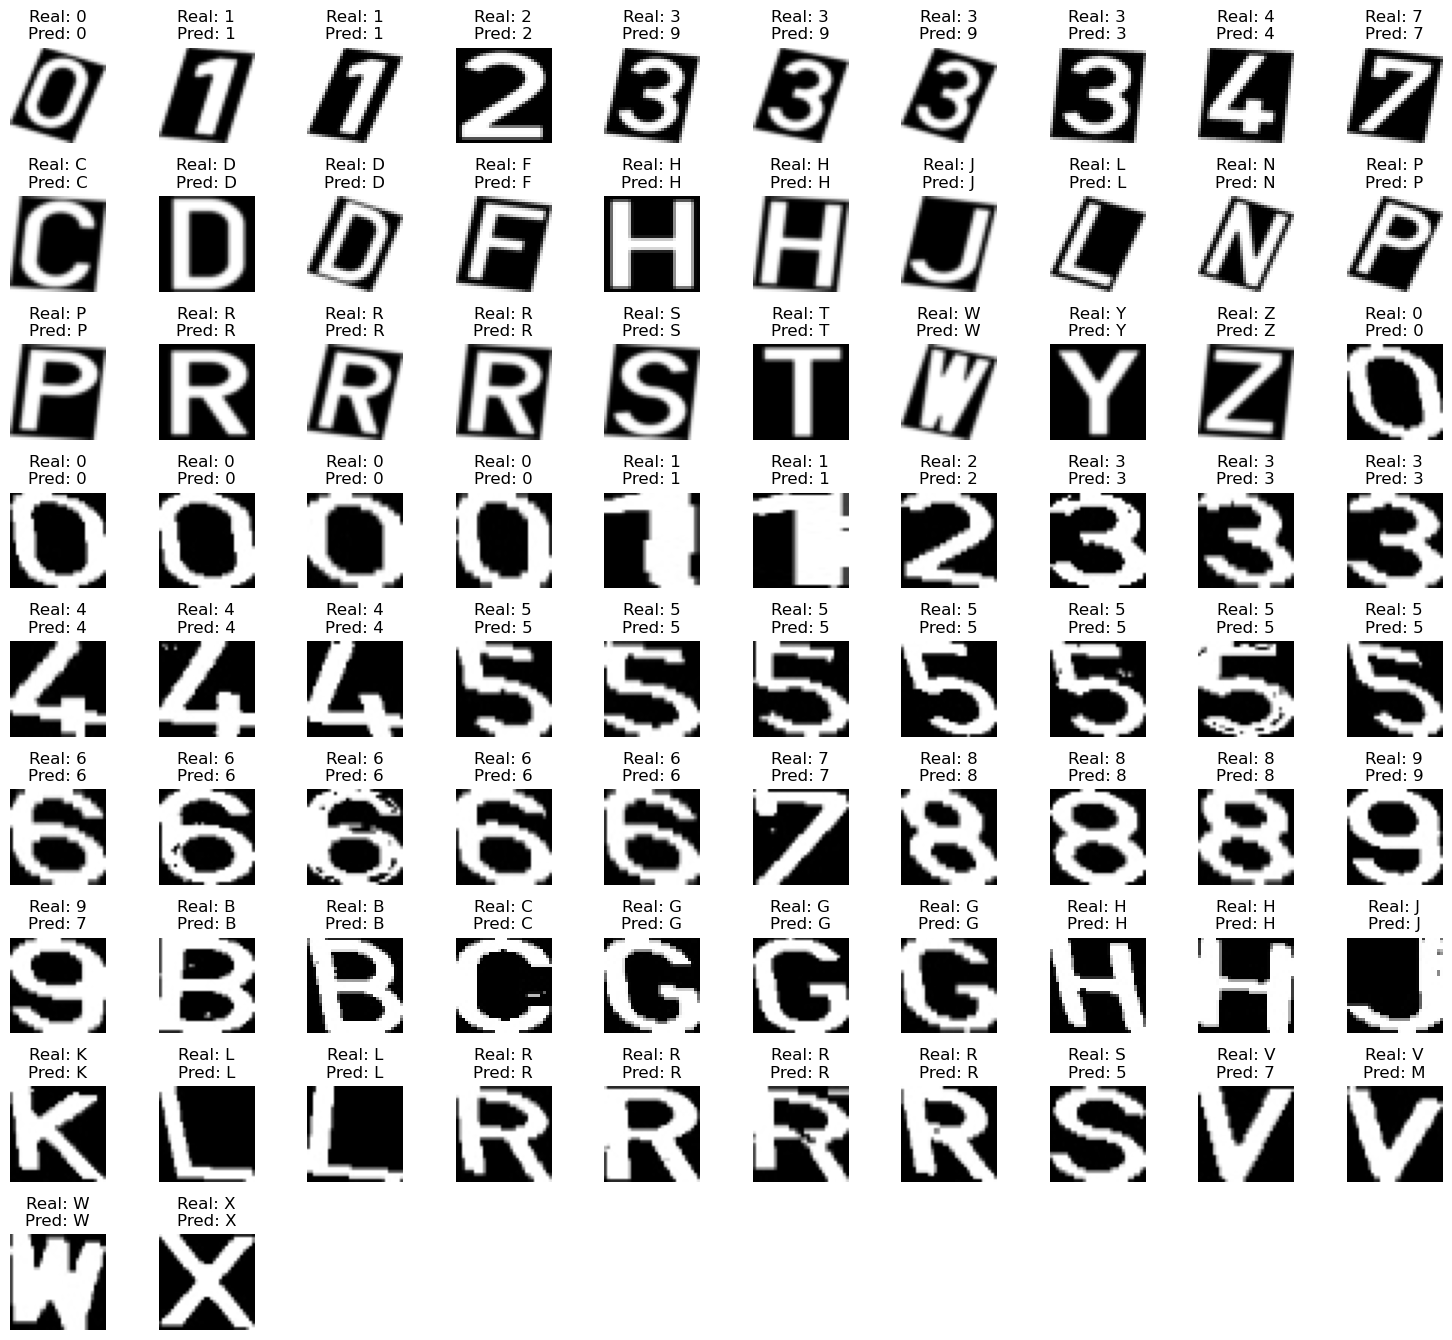

Fold 3 - Precisión: 1.00


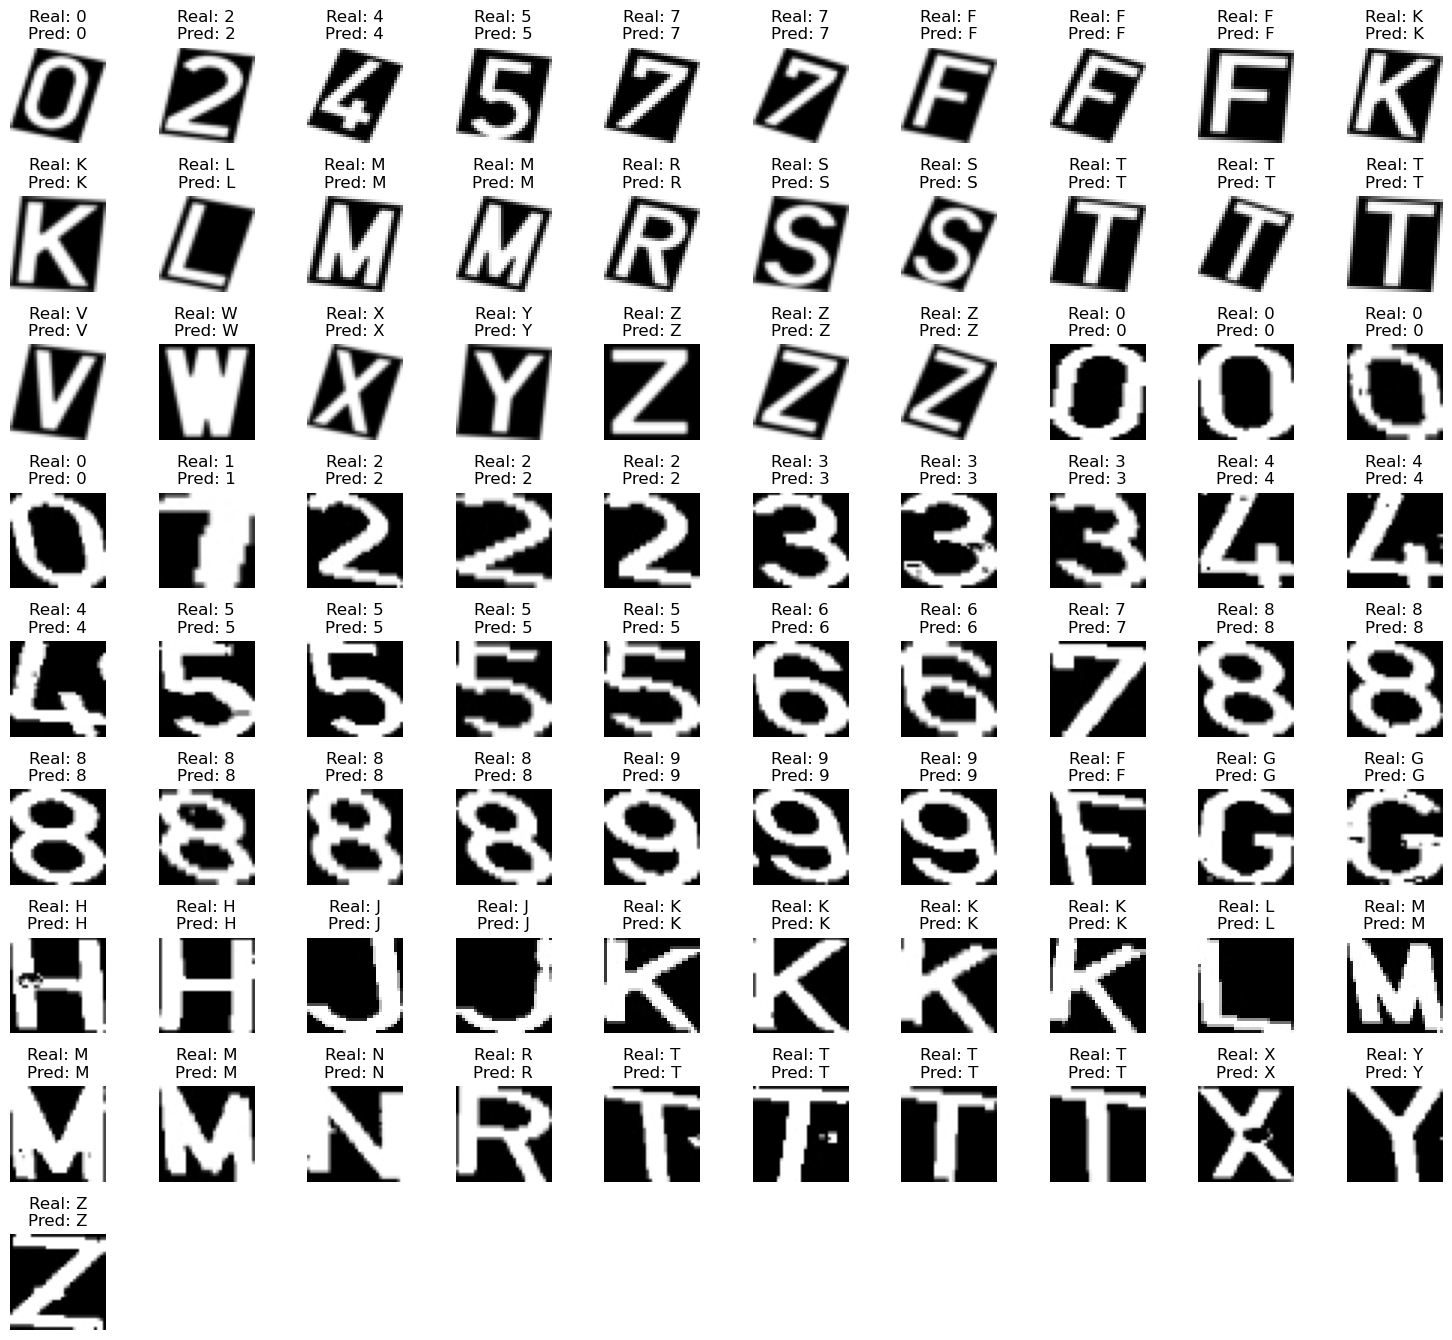

Fold 4 - Precisión: 0.95


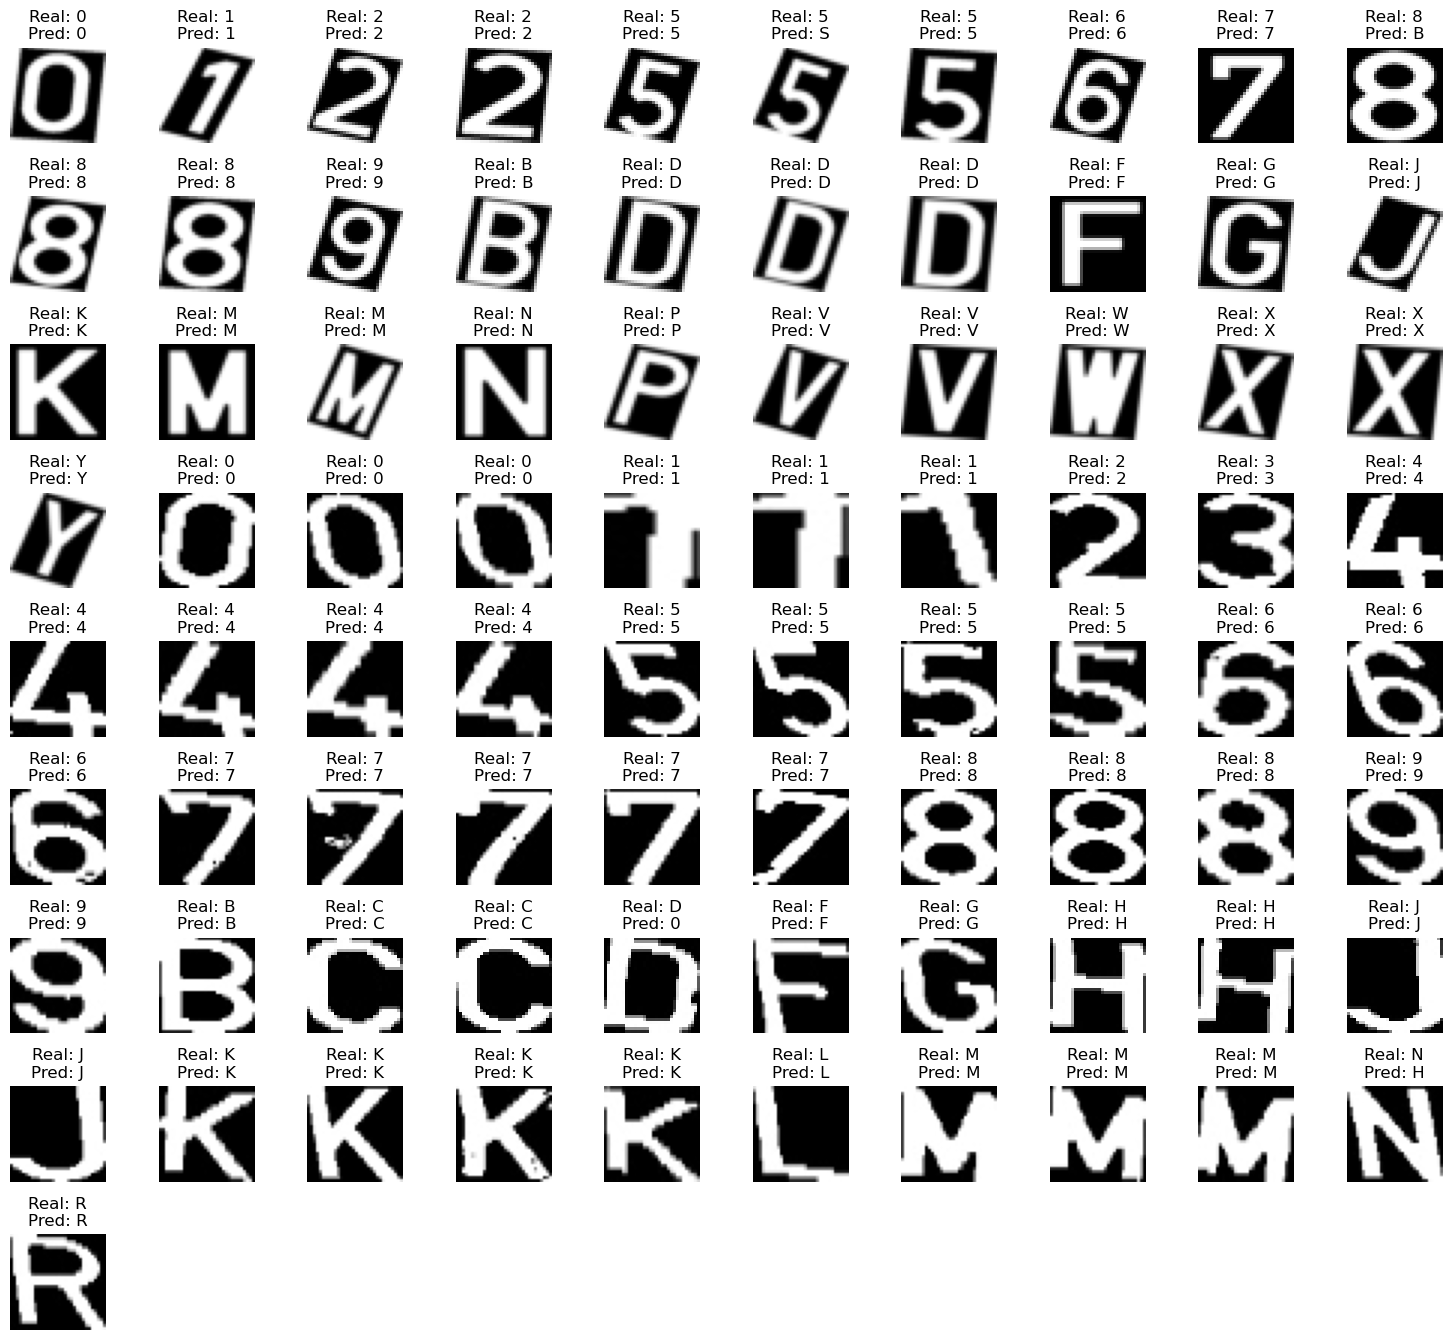

Fold 5 - Precisión: 0.94


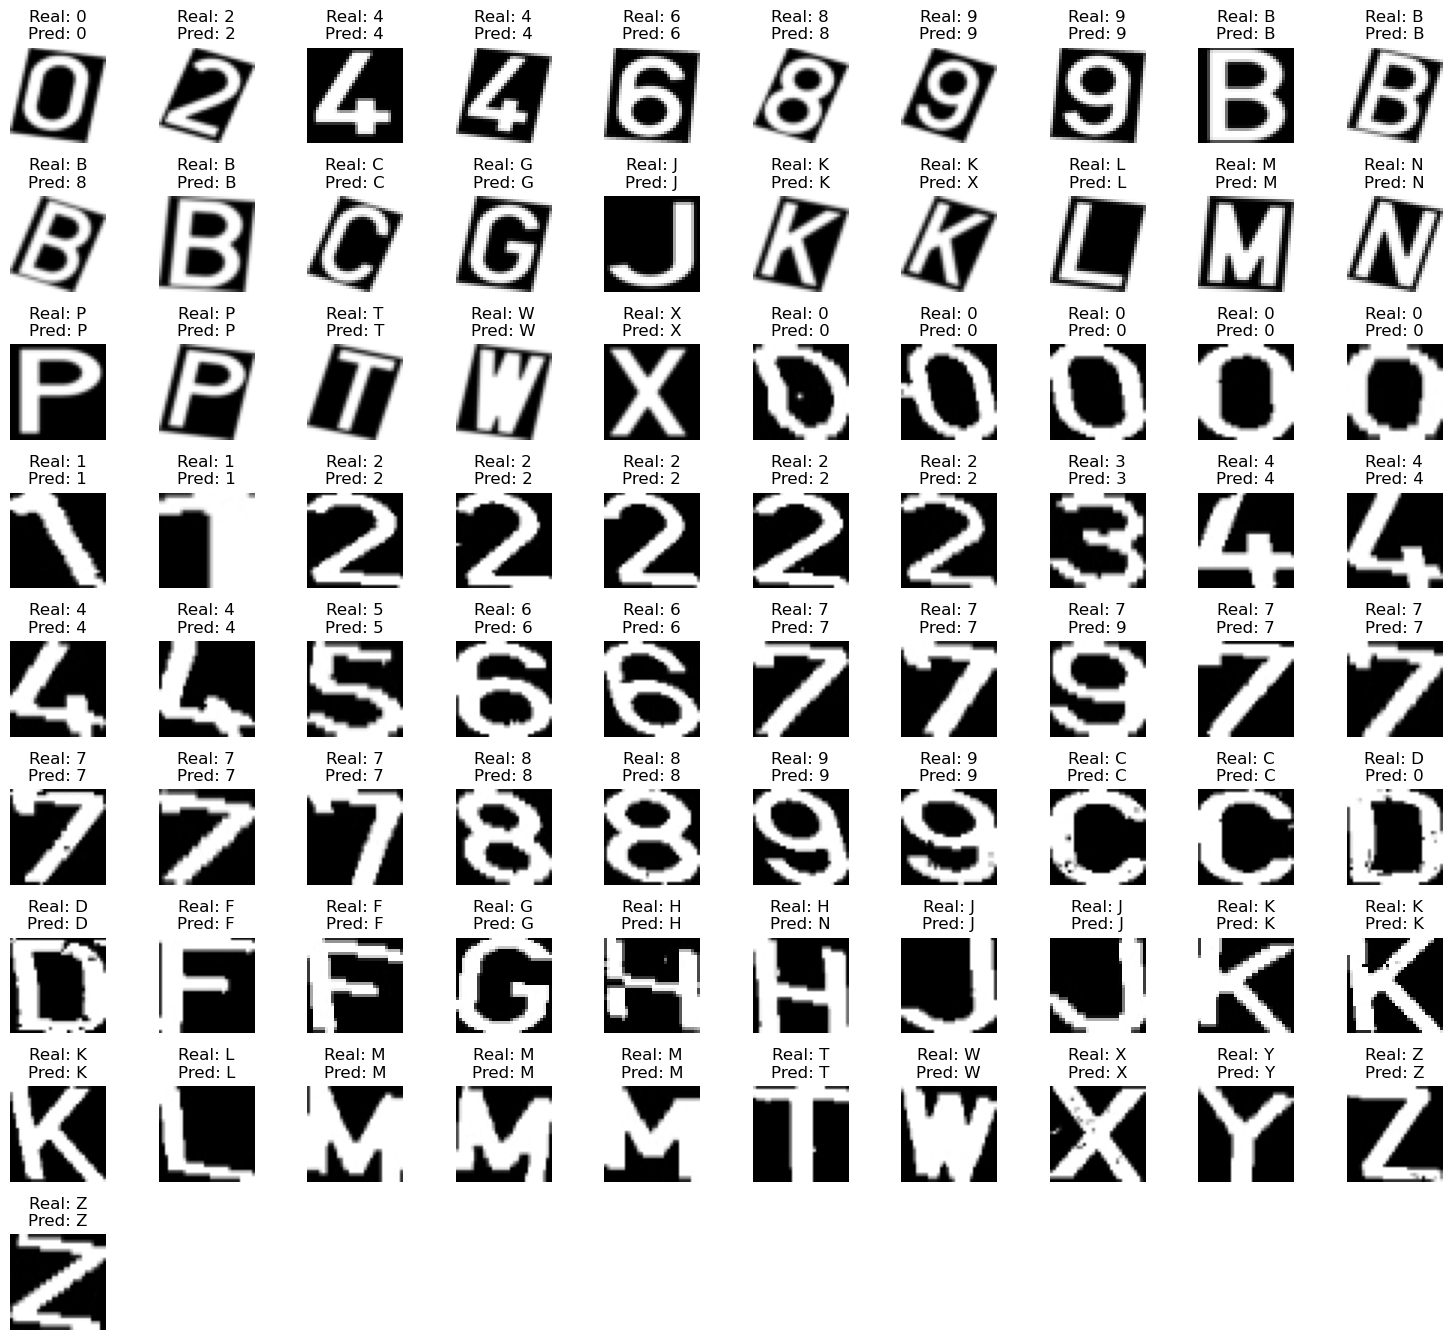

Precisión promedio en los 5 folds: 0.95
Intervalo de confianza del 95%: (0.9140674668538185, 0.9927076008968587)


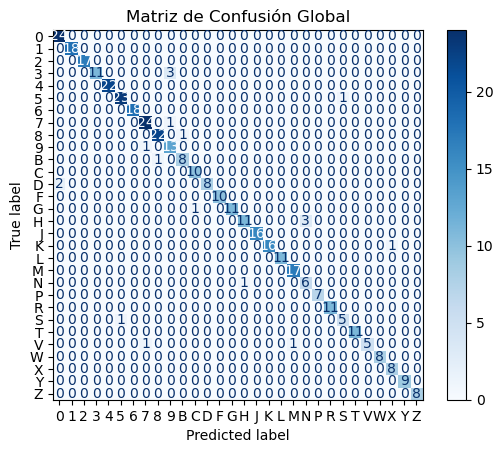

In [12]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
import scipy.stats as st


# PAS 1: Llegim les dades i les guardem en els arrays corresponents

# Llista de caracters alfanumèrics 
caracteres = '0123456789BCDFGHJKLMNPRSTVWXYZ'

data = []
target = []

# Trobem el directori actual
base_path =  os.getcwd()

# Per cada caracter busquem la seva carpeta corresponent on hi ha les imatges que s'han d'etiquetar amb el caracter.
for char in caracteres:
    folder_path = os.path.join(base_path, char)
    images, labels = load_images_from_folder_synthetic(folder_path, char)
    data.extend(images)
    target.extend(labels)

for char in caracteres:
    folder_path = os.path.join(base_path, f"predictions{char}")
    images, labels = load_images_from_folder_real(folder_path, char)
    data.extend(images)
    target.extend(labels)
    
# Convertim les dades en a arrays numpy
X = np.array(data)
Y = np.array(target)
    
# Cridem la funció per entrenar i avaluar el model amb KFolds
kf, all_y_true, all_y_pred, accuracies, clf = Train_KFolds(X,Y)
    
# Calculem la mitjana dels accuracies dels diferents Folds
mean_accuracy = np.mean(accuracies)
print(f'Precisión promedio en los {kf.n_splits} folds: {mean_accuracy:.2f}')

# Calculem l'interval de confiança del model

confidence_interval = st.t.interval(confidence=0.95, df=len(accuracies)-1, loc=mean_accuracy, scale=st.sem(accuracies))

print("Intervalo de confianza del 95%:", confidence_interval)

# Fem una matriu de confussió general per observar els resultats d'una manera més visual.
cm_global = confusion_matrix(all_y_true, all_y_pred)
disp_global = ConfusionMatrixDisplay(confusion_matrix=cm_global, display_labels=np.unique(Y))
disp_global.plot(cmap='Blues')
plt.title("Matriz de Confusión Global")
plt.show()



